In [1]:
! nvidia-smi

Sat Jan 15 16:50:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle 
! chmod 600 ~/.kaggle/kaggle.json 

In [4]:
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals 

 99% 651M/656M [00:05<00:00, 122MB/s]
100% 656M/656M [00:05<00:00, 119MB/s]


In [ ]:
! unzip animal-image-dataset-90-different-animals.zip

In [6]:
path = '/content/animals/animals'

In [7]:
import tensorflow as tf 
import keras 
from PIL import Image 
import os
from pathlib import Path 
import numpy as np 

tf.__version__

'2.7.0'

In [8]:
dir = Path(path)

In [9]:
cnt = len(list(dir.glob('*/*.jpg')))
cnt

5400

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [11]:
dog = list(dir.glob('dog/*'))
img = Image.open(str(dog[0]))
width, height = img.size 
width, height 

(225, 225)

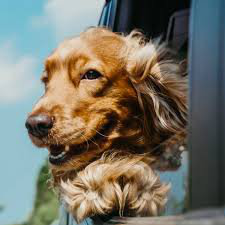

In [12]:
Image.open(dog[0])

In [13]:
batch_size = 32 
img_height = height 
img_width = width

In [25]:
train = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset='training',
    seed=123, 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dir, 
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, 
    seed=123,
    validation_split=0.1,
    subset = "validation"
)

Found 5400 files belonging to 90 classes.
Using 4320 files for training.
Found 5400 files belonging to 90 classes.
Using 540 files for validation.


In [26]:
final = len(train.class_names)
final

90

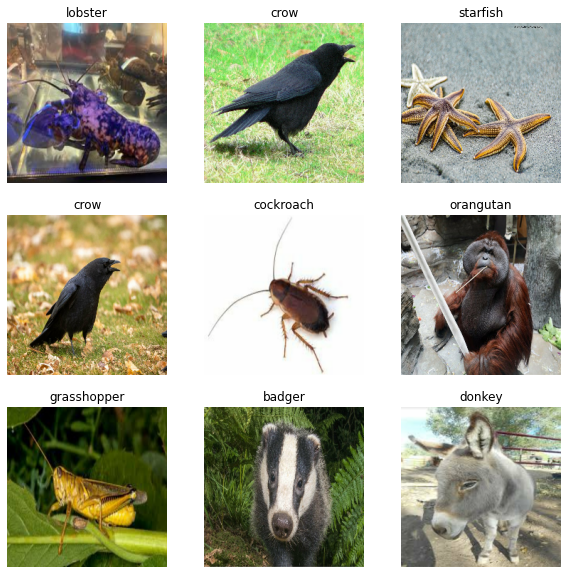

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train.class_names[labels[i]]) 
    plt.axis('off')

In [56]:
for i, l in train:
  print(i.shape, l.shape)
  break

(32, 225, 225, 3) (32,)


In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train = train.prefetch(
    buffer_size=AUTOTUNE
)

validation = validation.prefetch(
    buffer_size=AUTOTUNE
)

In [45]:
early_stop = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    verbose=1,
    monitor='val_loss',
    save_best_weight=True,
    model='auto'
)

In [63]:
resNet = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

resNet.trainable=True

In [64]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),                                 
])

In [65]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x1 = tf.keras.applications.resnet.preprocess_input(x)
x1 = resNet(x1, training=False)
x3 = tf.keras.layers.Dropout(0.2)(x1)
x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
outputs3 = tf.keras.layers.Dense(90)(x3)
model = tf.keras.Model(inputs=inputs, outputs=outputs3)

In [66]:
base_learning_rate = 0.00001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [53]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 2048)        0     

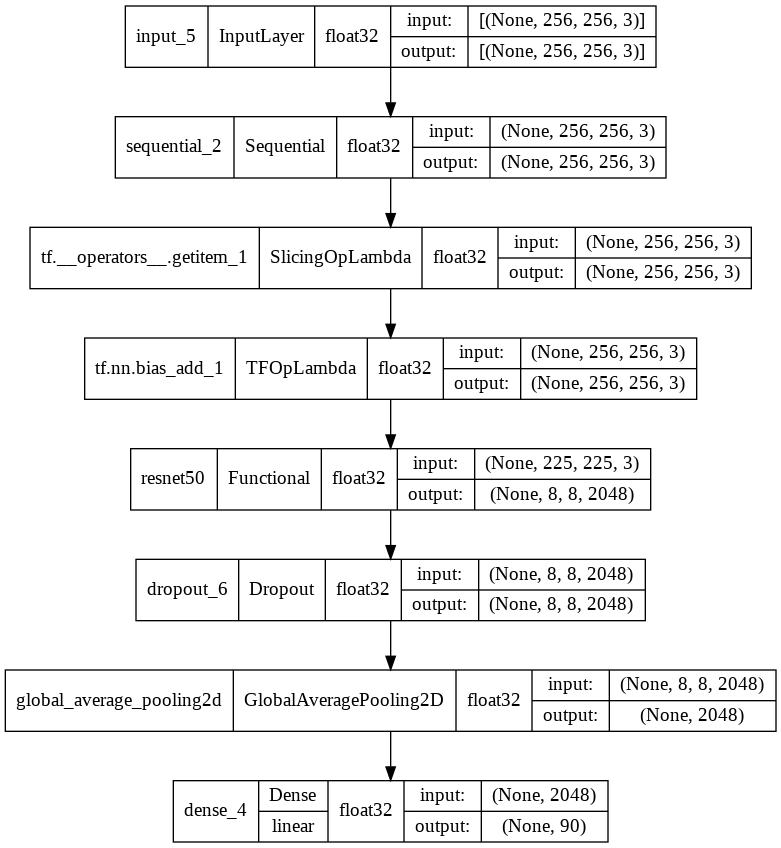

In [54]:
tf.keras.utils.plot_model(
    model,
    to_file='model.jpg',
    show_shapes=True, 
    show_dtype=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [67]:
history = model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=early_stop
)

Epoch 1/20
135/135 [==============================] - ETA: 0s - loss: 4.3878 - accuracy: 0.0447
Epoch 00001: saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


135/135 [==============================] - 67s 434ms/step - loss: 4.3878 - accuracy: 0.0447 - val_loss: 3.8010 - val_accuracy: 0.1352
Epoch 2/20
135/135 [==============================] - ETA: 0s - loss: 2.6676 - accuracy: 0.3637
Epoch 00002: saving model to model.h5
135/135 [==============================] - 59s 429ms/step - loss: 2.6676 - accuracy: 0.3637 - val_loss: 1.6999 - val_accuracy: 0.5556
Epoch 3/20
135/135 [==============================] - ETA: 0s - loss: 1.2727 - accuracy: 0.6595
Epoch 00003: saving model to model.h5
135/135 [==============================] - 59s 428ms/step - loss: 1.2727 - accuracy: 0.6595 - val_loss: 1.1633 - val_accuracy: 0.6593
Epoch 4/20
135/135 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.7704
Epoch 00004: saving model to model.h5
135/135 [==============================] - 59s 430ms/step - loss: 0.8076 - accuracy: 0.7704 - val_loss: 1.0078 - val_accuracy: 0.7241
Epoch 5/20
135/135 [==============================] - ETA: 0s 

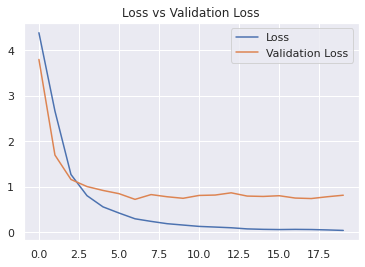

In [68]:
sns.set_theme()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs Validation Loss')
plt.show()

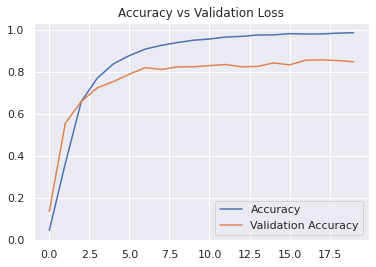

In [69]:
sns.set_theme()
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs Validation Loss')
plt.show()